In [1]:
import arviz as az
import os
import matplotlib.pyplot as plt
import pickle
from matplotlib import rc
import matplotlib.lines as mlines
import numpy as np
from typing import List, Optional
import pandas as pd
import numpyro

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
plt.style.use('default')
plt.rcParams['font.size'] = 12.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 0.4
plt.rcParams['lines.linewidth'] = 0.4
plt.rcParams['xtick.labelsize'] = 10
rc('text', usetex=True)

In [13]:
class emcee_result:  
    
    def __init__(self, filename):
        var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
       "w_0" :  r"$w_0$",
       "w_1" : r"$w_1$",
       "alpha" : r"$\alpha$"} 
        
        idata = az.from_netcdf(filename)
        self.idata = idata
        self.dim = len(idata.posterior)
        self.idata_rename = self.idata.rename(var_dict)
        
    def trace(self, axes=None):
        labeller = az.labels.MapLabeller(var_name_map=var_dict)
        az.plot_trace(self.idata, axes=axes, labeller=labeller)
        
    def summary(self,burnin):
        idata = self.idata_rename.sel(draw=slice(burnin, None))
        rename_dict = {'hdi_16%':'hdi 16\%',
                      'hdi_84%':'hdi 84\%',
                      'sd':r'$\sigma$',
                      'r_hat':r'$\hat{R}$'}
        
        summary = az.summary(idata, hdi_prob=0.68)
        summary = summary.drop(columns=['mcse_mean', 'mcse_sd', 'ess_bulk', 'ess_tail'])
        summary = summary.rename(columns=rename_dict)
        
        return summary
    
    def converged_plot(self, burnin, ax=None):
        a,b = np.shape(self.idata.posterior['Omega_m'])
        arr = np.array([100*int(i/100) for i in np.geomspace(1,b, 20)])
        for i in arr:
            s = self.idata.sel(draw=slice(burnin, i))
            samples = s.posterior['Omega_m'].values
            az.plot_kde(samples, ax=ax)

In [8]:
class numpyro_result:
    
    
    
    def __init__(self, filename):
        var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
       "w_0" :  r"$w_0$",
       "w_1" : r"$w_1$",
       "alpha" : r"$\alpha$"} 
        
        with open(filename, 'rb') as f:
            res_dict = pickle.load(f) 
        self.losses = res_dict['losses']
        self.samples = res_dict['samples']
        self.params = res_dict['params']
        self.quantiles = res_dict['quantiles']
        self.idata = az.from_dict(self.samples[list(self.samples.keys())[-1]], var_names=var_dict.values())
        self.idata_rename = self.idata.rename(var_dict)
        
    def plot_losses(self, ax=None, kwargs=dict()):
        if ax:
            ax.plot(self.losses, **kwargs)
        else:
            plt.plot(self.losses, **kwargs)
            
            
    def plot_samples(self, ax=None, all=True, key='Omega_m'):
        
        par_dict =  self.convert_param_to_steps()
    
        if all == True:
            color = iter(plt.cm.rainbow(np.linspace(0, 1, len(self.samples.values()))))
            handles = []
            for i in self.samples.keys():
                s = self.samples[i]
                c = next(color)
                O = s[key]
                az.plot_kde(O, plot_kwargs=dict(color=c), ax=ax)
                try:
                    label=par_dict[i]
                    h = mlines.Line2D([], [], color=c, label=label)
                    handles += [h]
                except KeyError:
                    pass
                    
            
            
        else:
            s = self.samples[list(self.samples.keys())[-1]]['Omega_m']
            az.plot_kde(s, ax=ax)
         
        return handles
    
    def summary(self):
        rename_dict = {'hdi_16%':'hdi 16\%',
              'hdi_84%':'hdi 84\%',
              'sd':r'$\sigma$',
              'r_hat':r'$\hat{R}$'}
        summary = az.summary(self.idata_rename, hdi_prob=0.68, kind='stats')
        summary = summary.rename(columns=rename_dict)
        return summary
    
    def convert_param_to_steps(self):
        grad_steps = len(self.losses)
        arr = np.array([100*int(i/100) for i in np.geomspace(1,grad_steps,20)])
        arr_cut = np.unique(arr)
        if len(arr_cut) == len(self.samples.keys()):
            zipped = zip(self.samples.keys(), arr_cut)
            par_dict = dict(zipped)
        else:
            print('keys and values do not have the same shape')
            par_dict = dict()
        
        return par_dict


In [9]:
arr = np.geomspace(1, 50000, 20)
arr_cut = np.unique(arr)


In [10]:
def plot_results(idata, burnin, var_names: Optional[List[str]] = None, kde_kwargs=None,
        marginal_kwargs=None, dist_kwargs=dict(), ax=None, name=None):
    
    var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
                   "w_0" :  r"$w_0$",
                   "w_1" : r"$w_1$",
                   "alpha" : r"$\alpha$"}   
        
    labeller = az.labels.MapLabeller(var_name_map=var_dict)
    
    idata = idata.sel(draw=slice(burnin, None))

    if len(idata.posterior) == 1: 
        vals = np.concatenate(idata.posterior["Omega_m"].values)
        az.plot_dist(vals, ax=ax, label=name, **dist_kwargs)
    else:
        az.plot_pair(idata, kind='kde', marginals=True, figsize=(10,10), textsize=16, ax=ax, 
                    kde_kwargs=kde_kwargs, marginal_kwargs=marginal_kwargs, contour=False, labeller=labeller)

# Load $\Lambda$CDM data

In [11]:
data_dir_num = '../scripts/numpyro_results/'
lcdm_ni0p0 = numpyro_result(data_dir_num + 'lcdm_prior0_init_0_0.001.pickle')
lcdm_ni1p0 = numpyro_result(data_dir_num + 'lcdm_prior0_init_1_0.001.pickle')
lcdm_ni0p1 = numpyro_result(data_dir_num + 'lcdm_prior1_init_0_0.001.pickle')
lcdm_ni1p1 = numpyro_result(data_dir_num + 'lcdm_prior1_init_1_0.001.pickle')
lcdm_ni1p3 = numpyro_result(data_dir_num + 'lcdm_prior3_init_1_0.001.pickle')
lcdm_ni1p3_s = numpyro_result(data_dir_num + 'lcdm_s_prior_init_1_0.0001.pickle')

In [14]:
data_dir_em = '../scripts/emcee_results/'
lcdm_ei0p0 = emcee_result(data_dir_em +'lcdm_init0_prior0.nc')
lcdm_ei0p1 = emcee_result(data_dir_em +'lcdm_init0_prior1.nc')
lcdm_ei1p0 = emcee_result(data_dir_em +'lcdm_init1_prior0.nc')
lcdm_ei1p1 = emcee_result(data_dir_em +'lcdm_init1_prior1.nc')
lcdm_ei1p3 = emcee_result(data_dir_em +'lcdm_init1_prior3.nc')

In [15]:
sum_p0 = pd.concat([lcdm_ei0p0.summary(burnin=1000), lcdm_ei1p0.summary(burnin=1000)], keys=['Initial 1', 'Initial 2'])
sum_p1 = pd.concat([lcdm_ei0p1.summary(burnin=1000), lcdm_ei1p1.summary(burnin=1000)], keys=['Initial 1', 'Initial 2'])
sum_p2 = pd.concat([lcdm_ei1p3.summary(1000)], keys=['Initial 2'])
sum_pd = pd.concat([sum_p0, sum_p1, sum_p2], keys=['Prior 1', 'Prior 2', 'Prior 2 ext.'])
print(sum_pd.to_latex(escape=False))

\begin{tabular}{lllrrrrr}
\toprule
             &           &                &   mean &  $\sigma$ &  hdi 16\% &  hdi 84\% &  $\hat{R}$ \\
\midrule
Prior 1 & Initial 1 & $\Omega_{m,0}$ &  0.289 &     0.008 &     0.281 &     0.298 &        1.0 \\
             & Initial 2 & $\Omega_{m,0}$ &  0.289 &     0.008 &     0.281 &     0.298 &        1.0 \\
Prior 2 & Initial 1 & $\Omega_{m,0}$ &  0.308 &     0.005 &     0.303 &     0.313 &        1.0 \\
             & Initial 2 & $\Omega_{m,0}$ &  0.308 &     0.005 &     0.303 &     0.313 &        1.0 \\
Prior 2 ext. & Initial 2 & $\Omega_{m,0}$ &  0.297 &     0.008 &     0.289 &     0.305 &        1.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_28133/974742913.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sum_pd.to_latex(escape=False))


In [16]:
sum_p0 = pd.concat([lcdm_ni0p0.summary(), lcdm_ni1p0.summary()], keys=['Initial 1', 'Initial 2'])
sum_p1 = pd.concat([lcdm_ni0p1.summary(), lcdm_ni1p1.summary()], keys=['Initial 1', 'Initial 2'])
sum_p2 = pd.concat([lcdm_ni1p3.summary()], keys=['Initial 2'])
sum_p2_s = pd.concat([lcdm_ni1p3_s.summary()], keys=['Initial 2'])
sum_pd = pd.concat([sum_p0, sum_p1, sum_p2, sum_p2_s], keys=['Prior 1', 'Prior 2', 'Prior 2 ext.', 'Prior 2 ext., S=10'])
print(sum_pd.to_latex(escape=False))

\begin{tabular}{lllrrrr}
\toprule
                   &           &                &   mean &  $\sigma$ &  hdi 16\% &  hdi 84\% \\
\midrule
Prior 1 & Initial 1 & $\Omega_{m,0}$ &  0.289 &     0.008 &     0.281 &     0.297 \\
                   & Initial 2 & $\Omega_{m,0}$ &  0.289 &     0.008 &     0.281 &     0.297 \\
Prior 2 & Initial 1 & $\Omega_{m,0}$ &  0.303 &     0.006 &     0.297 &     0.309 \\
                   & Initial 2 & $\Omega_{m,0}$ &  0.303 &     0.006 &     0.297 &     0.309 \\
Prior 2 ext. & Initial 2 & $\Omega_{m,0}$ &  0.292 &     0.008 &     0.284 &     0.300 \\
Prior 2 ext., S=10 & Initial 2 & $\Omega_{m,0}$ &  0.292 &     0.008 &     0.284 &     0.300 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_28133/3883903956.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sum_pd.to_latex(escape=False))


/home/jakob/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jakob/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jakob/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jakob/.local/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/jakob/.local/lib/python3.10/site-packages/arviz/st

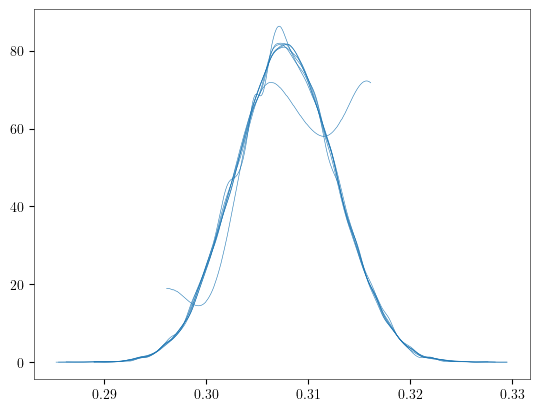

In [243]:
lcdm_ei0p1.converged_plot(burnin=1000)

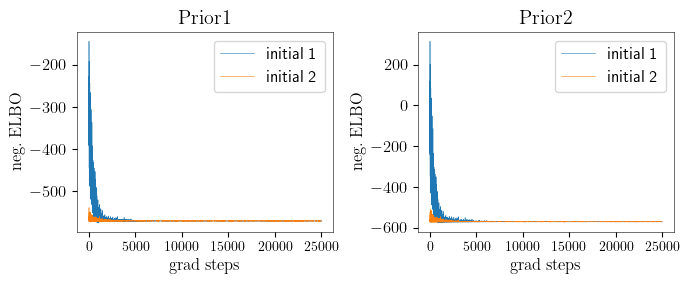

In [244]:
fig7, axes7 = plt.subplots(1,2, figsize=(7,3))

lcdm_ni0p0.plot_losses(axes7[0], kwargs={'label':'initial 1'})  
lcdm_ni1p0.plot_losses(axes7[0], kwargs={'label':'initial 2'})  

axes7[0].legend()
axes7[0].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes7[0].set_xlabel(r'$\mathrm{grad\; steps}$')
axes7[0].set_title(r'$\mathrm{Prior 1}$')


lcdm_ni0p1.plot_losses(axes7[1], kwargs={'label':'initial 1'})  
lcdm_ni1p1.plot_losses(axes7[1],kwargs={'label':'initial 2'})  

axes7[1].legend()
axes7[1].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes7[1].set_xlabel(r'$\mathrm{grad\; steps}$')
axes7[1].set_title(r'$\mathrm{Prior 2}$')
fig7.tight_layout()
fig7.savefig('../plots/lcdm_losses.pdf')

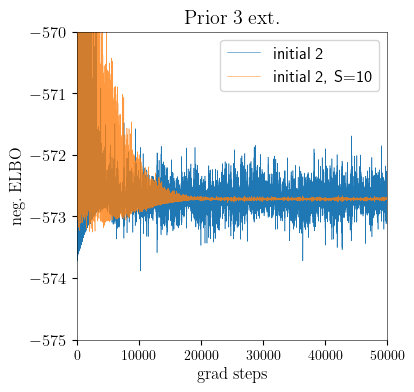

In [282]:
fig7, axes7 = plt.subplots(1,1, figsize=(4,4))

lcdm_ni1p3.plot_losses(axes7, kwargs={'label':'initial 2'}) 
lcdm_ni1p3_s.plot_losses(axes7, kwargs={'label':'initial 2, S=10', 'alpha':0.8})

axes7.legend()
axes7.set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes7.set_xlabel(r'$\mathrm{grad\; steps}$')
axes7.set_title(r'$\mathrm{Prior\; 3 \; ext.}$')
axes7.set_ylim(-575, -570)
axes7.set_xlim(0,50000);
fig7.savefig('../plots/lcdm_losses_ext.pdf')

In [160]:
var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
           "w_0" :  r"$w_0$",
           "w_1" : r"$w_1$",
           "alpha" : r"$\alpha$"}   
labeller = az.labels.MapLabeller(var_name_map=var_dict)

/tmp/ipykernel_24472/4007401.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


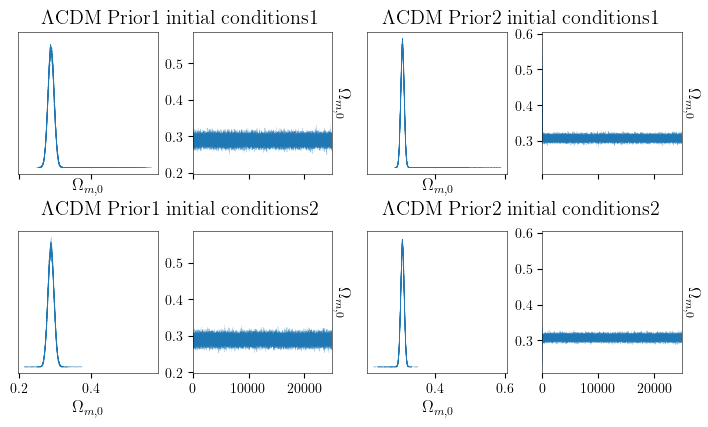

In [352]:
fig1, axes1 = plt.subplots(2,4, sharey='col', sharex='col', figsize=(7,4), gridspec_kw = {'wspace':0.25, 'hspace':0.4})

ax1 = fig1.add_subplot(221, frameon=False)
ax1.set_title(r'$\Lambda\mathrm{CDM \; Prior 1 \; initial\; conditions 1}$')
ax1.set_xticks([])
ax1.set_yticks([])
az.plot_trace(lcdm_ei0p0.idata, axes=axes1[[0],0:2], labeller=labeller)

ax2 = fig1.add_subplot(223, frameon=False)
ax2.set_title(r'$\Lambda\mathrm{CDM \; Prior 1 \; initial\; conditions 2}$')
ax2.set_xticks([])
ax2.set_yticks([])
az.plot_trace(lcdm_ei1p0.idata, axes=axes1[[1],0:2], labeller=labeller)

ax3 = fig1.add_subplot(222, frameon=False)
ax3.set_title(r'$\Lambda\mathrm{CDM \; Prior 2 \; initial\; conditions 1}$')
ax3.set_xticks([])
ax3.set_yticks([])
az.plot_trace(lcdm_ei0p1.idata, axes=axes1[[0],2:], labeller=labeller)

ax4 = fig1.add_subplot(224, frameon=False)
ax4.set_title(r'$\Lambda\mathrm{CDM \; Prior 2 \; initial \; conditions 2}$')
ax4.set_xticks([])
ax4.set_yticks([])
az.plot_trace(lcdm_ei1p1.idata, axes=axes1[[1],2:], labeller=labeller)

for a in axes1:
    a[0].set_title('')
    a[1].set_title('')
    a[2].set_title('')
    a[3].set_title('')
    a[0].set_xlabel(r"$\Omega_{m,0}$")
    a[1].yaxis.set_label_position("right")
    a[3].yaxis.set_label_position("right")
    a[1].set_ylabel(r"$\Omega_{m,0}$", rotation=270, labelpad=12)
    a[2].set_xlabel(r"$\Omega_{m,0}$")
    a[3].set_ylabel(r"$\Omega_{m,0}$", rotation=270, labelpad=12)

fig1.tight_layout()
fig1.savefig('../plots/lcdm_trace.pdf', bbox_inches='tight')

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

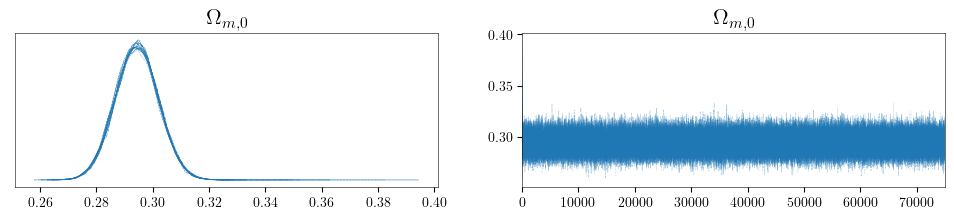

In [54]:
ax1 = az.plot_trace(lcdm_ei1p3.idata, labeller=labeller)
ax1.set_title(r'$\Lambda\mathrm{CDM \; Prior 3 \; initial\; conditions 2}$');

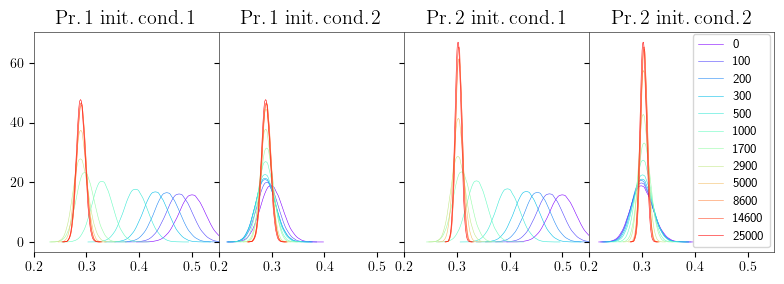

In [334]:
fig2, axes2 = plt.subplots(1,4, figsize=(8,3), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})
h = lcdm_ni0p0.plot_samples(axes2[0])
lcdm_ni0p1.plot_samples(axes2[2])
lcdm_ni1p0.plot_samples(axes2[1])
lcdm_ni1p1.plot_samples(axes2[3])

axes2[0].set_title(r'$\mathrm{Pr. \,1 \; init. \,cond. \,1}$'),
axes2[2].set_title(r'$\mathrm{Pr. \,2 \; init. \,cond. \,1}$'),
axes2[1].set_title(r'$\mathrm{Pr. \,1 \; init. \,cond. \,2}$'),
axes2[3].set_title(r'$\mathrm{Pr. \,2 \; init. \,cond. \,2}$'),

[axes2[i].set_xlim(0.2, 0.55) for i in range(3)]

fig2.legend(handles=h, bbox_to_anchor=(-0.02,-0.12,1,1), prop={'size': 9})
fig2.tight_layout();
fig2.savefig('../plots/numypro_lcdm_convergence.pdf');

In [18]:
m_Omega = 0.3166
s_Omega = 0.0084
x_arr = np.linspace(0.25, 0.33, 1000)
prior_2 = 1/np.sqrt(2*np.pi*s_Omega**2)*np.exp(-0.5*(x_arr-m_Omega)**2/s_Omega**2)

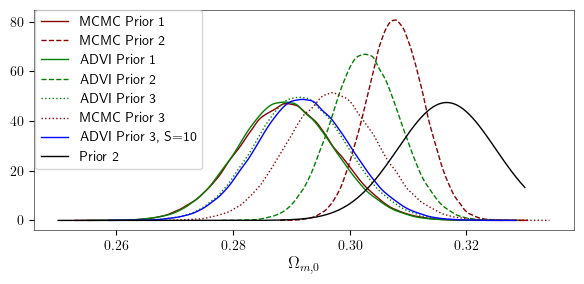

In [19]:
fig3, ax3 = plt.subplots(figsize=(6,3))
plot_results(lcdm_ei1p0.idata, 1000, ax=ax3, name='MCMC Prior 1', dist_kwargs={'color':'darkred', 'plot_kwargs':{'linewidth':1}})
plot_results(lcdm_ei1p1.idata, 1000, ax=ax3, name='MCMC Prior 2', dist_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dashed', 'linewidth':1}})
plot_results(lcdm_ni1p0.idata, 0, ax=ax3, name='ADVI Prior 1', dist_kwargs={'color':'green', 'plot_kwargs':{'linewidth':1}})
plot_results(lcdm_ni1p1.idata, 0, ax=ax3, name='ADVI Prior 2', dist_kwargs={'color':'green', 'plot_kwargs':{'linestyle':'dashed', 'linewidth':1}})
plot_results(lcdm_ni1p3.idata, 0, ax=ax3, name='ADVI Prior 3', dist_kwargs={'color':'green', 'plot_kwargs':{'linestyle':'dotted', 'linewidth':1}})
plot_results(lcdm_ei1p3.idata, 1000, ax=ax3, name='MCMC Prior 3', dist_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dotted', 'linewidth':1}})
plot_results(lcdm_ni1p3_s.idata, 0, ax=ax3, name='ADVI Prior 3, S=10', dist_kwargs={'color':'blue', 'plot_kwargs':{'linestyle':'-', 'linewidth':1}})
ax3.plot(x_arr, prior_2, 'k', linewidth=1, label='Prior 2')
ax3.set_xlabel(r'$\Omega_{m,0}$')
ax3.legend(bbox_to_anchor=(-0.01,+0.03,1,1),prop={'size':10})
fig3.tight_layout()
fig3.savefig('../plots/lcdm_comparison.pdf')

# Load CPL data

In [360]:
cpl_ni0p0 = numpyro_result(data_dir_num + 'cpl_prior0_init_0_0.001.pickle')
cpl_ni1p0 = numpyro_result(data_dir_num + 'cpl_prior0_init_1_0.001.pickle')
cpl_ni0p1 = numpyro_result(data_dir_num + 'cpl_prior1_init_0_0.001.pickle')
cpl_ni1p1 = numpyro_result(data_dir_num + 'cpl_prior1_init_1_0.001.pickle')
cpl_ni0p2 = numpyro_result(data_dir_num + 'cpl_prior2_init_0_0.001.pickle')
cpl_ni1p2 = numpyro_result(data_dir_num + 'cpl_prior2_init_1_0.001.pickle')
#cpl_ni0p3 = numpyro_result(data_dir_num + 'cpl_prior3_init_0_0.001.pickle')
#cpl_ni1p3 = numpyro_result(data_dir_num + 'cpl_prior3_init_1_0.001.pickle')


In [136]:
cpl_ei0p0 = emcee_result(data_dir_em +'cpl_init0_prior0.nc')
cpl_ei0p1 = emcee_result(data_dir_em +'cpl_init0_prior1.nc')
cpl_ei1p0 = emcee_result(data_dir_em +'cpl_init1_prior0.nc')
cpl_ei1p1 = emcee_result(data_dir_em +'cpl_init1_prior1.nc')
cpl_ei1p2 = emcee_result(data_dir_em +'cpl_init1_prior2.nc')

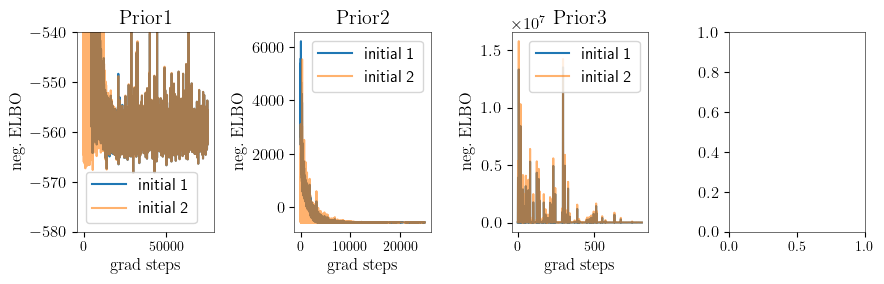

In [142]:
fig8, axes8 = plt.subplots(1,4, figsize=(9,3))

cpl_ni0p0.plot_losses(axes8[0], kwargs={'label':'initial 1', 'linewidth':1.5})  
cpl_ni1p0.plot_losses(axes8[0],kwargs={'label':'initial 2', 'alpha':0.6, 'linewidth':1.5})  
axes8[0].legend()
axes8[0].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes8[0].set_xlabel(r'$\mathrm{grad\; steps}$')
axes8[0].set_title(r'$\mathrm{Prior 1}$')
axes8[0].set_ylim(-580, -540)

 
cpl_ni0p1.plot_losses(axes8[1], kwargs={'label':'initial 1', 'linewidth':1.5})  
cpl_ni1p1.plot_losses(axes8[1],kwargs={'label':'initial 2', 'alpha':0.6, 'linewidth':1.5})  
axes8[1].legend()
axes8[1].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes8[1].set_xlabel(r'$\mathrm{grad\; steps}$')
axes8[1].set_title(r'$\mathrm{Prior2}$')


cpl_ni0p2.plot_losses(axes8[2], kwargs={'label':'initial 1', 'linewidth':1.5})  
cpl_ni1p2.plot_losses(axes8[2],kwargs={'label':'initial 2', 'alpha':0.6, 'linewidth':1.5})  
axes8[2].legend()
axes8[2].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes8[2].set_xlabel(r'$\mathrm{grad\; steps}$')
axes8[2].set_title(r'$\mathrm{Prior3}$')

fig8.tight_layout()
#fig8.savefig('../plots/cpl_losses.pdf')

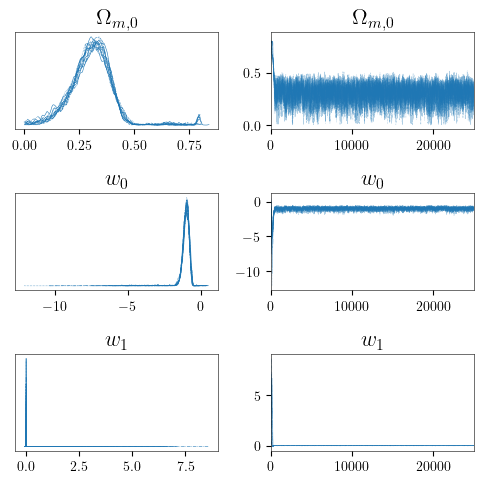

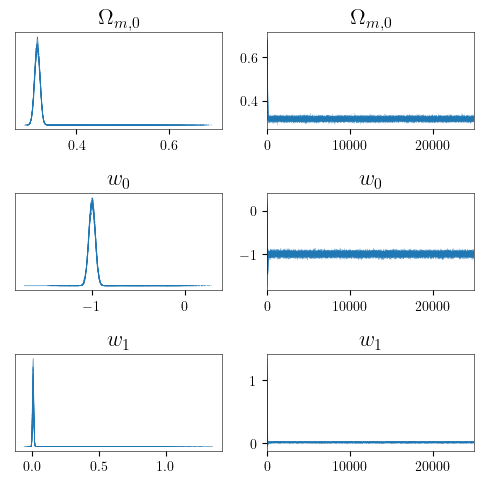

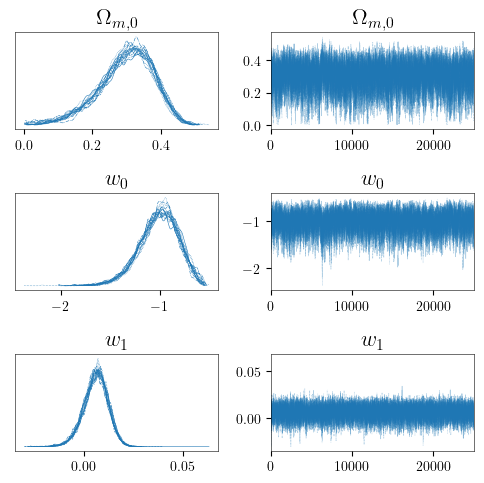

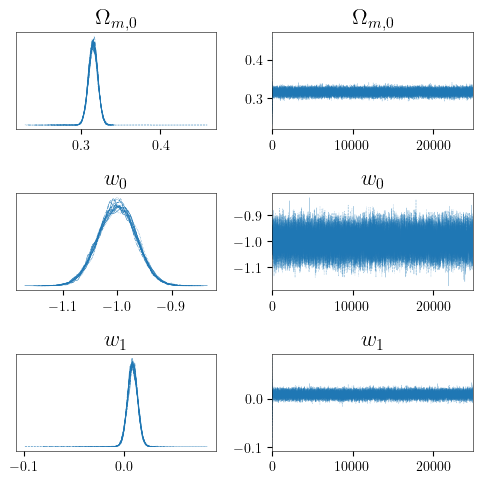

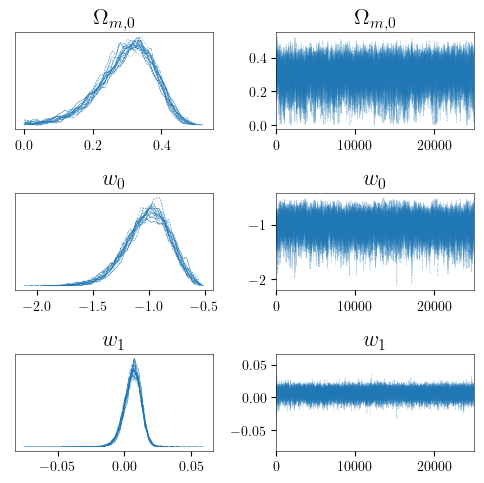

In [56]:
fig2, axes2 = plt.subplots(3,2, figsize=(5,5))
cpl_ei0p0.trace(axes=axes2)
plt.tight_layout()
fig2.savefig('../plots/cpl_ei0p0_trace.pdf')

fig3, axes3 = plt.subplots(3,2, figsize=(5,5))
cpl_ei0p1.trace(axes=axes3)
plt.tight_layout()
fig3.savefig('../plots/cpl_ei0p1_trace.pdf')

fig4, axes4 = plt.subplots(3,2, figsize=(5,5))
cpl_ei1p0.trace(axes=axes4)
plt.tight_layout()
fig4.savefig('../plots/cpl_ei1p0_trace.pdf')

fig5, axes5 = plt.subplots(3,2, figsize=(5,5))
cpl_ei1p1.trace(axes=axes5)
plt.tight_layout()
fig5.savefig('../plots/cpl_ei1p1_trace.pdf')

fig6, axes6 = plt.subplots(3,2, figsize=(5,5))
cpl_ei1p2.trace(axes=axes6)
plt.tight_layout()
fig6.savefig('../plots/cpl_ei1p2_trace.pdf')

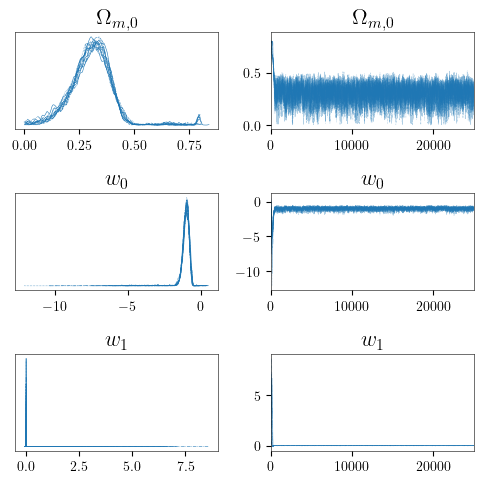

In [57]:
fig12, axes12 = plt.subplots(3,2, figsize=(5,5))
cpl_ei0p0.idata.sel(chain=[0,1,2,3,4,5,6,8,9,10,11,12,13,14], inplace=True)
cpl_ei0p0.trace(axes=axes12)
plt.tight_layout()

0
100
200
300
600
1100
2100
3900
7000
12700
23000
41500
75000
0
100
200
300
500
1000
1700
2900
5000
8600
14600
25000
0
100
200
300
600
1100
2100
3900
7000
12700
23000
41500
75000
0
100
200
300
500
1000
1700
2900
5000
8600
14600
25000


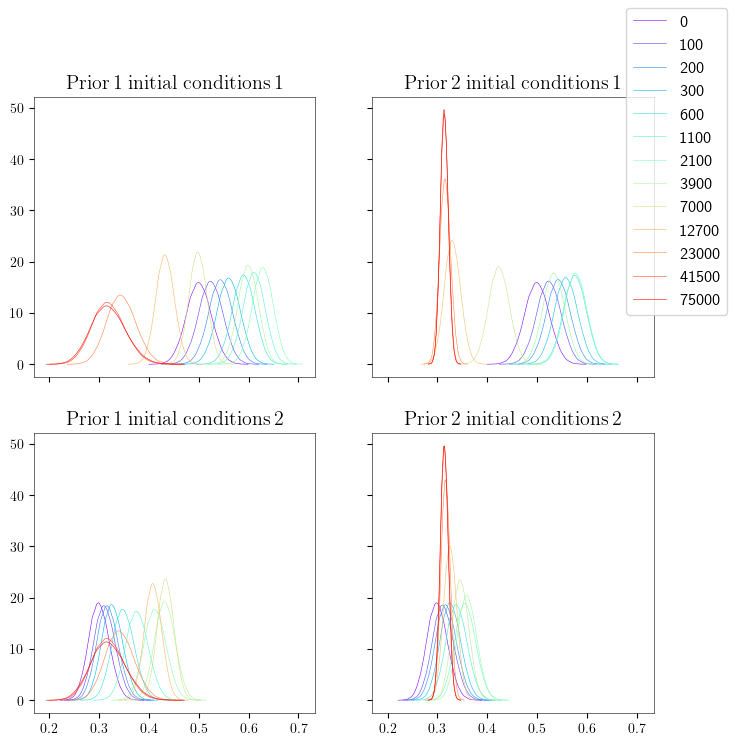

In [184]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True, gridspec_kw={'wspace=0.0', 'hspace=0.0'})
h = cpl_ni0p0.plot_samples(axes2[0,0])
cpl_ni0p1.plot_samples(axes2[0,1])
cpl_ni1p0.plot_samples(axes2[1,0])
cpl_ni1p1.plot_samples(axes2[1,1])

axes2[0,0].set_title(r'$\mathrm{Prior \,1 \; initial\; conditions \,1}$'),
axes2[0,1].set_title(r'$\mathrm{Prior \,2 \; initial\; conditions \,1}$'),
axes2[1,0].set_title(r'$\mathrm{Prior \,1 \; initial\; conditions \,2}$'),
axes2[1,1].set_title(r'$\mathrm{Prior \,2 \; initial\; conditions \,2}$'),

fig2.legend(handles=h)

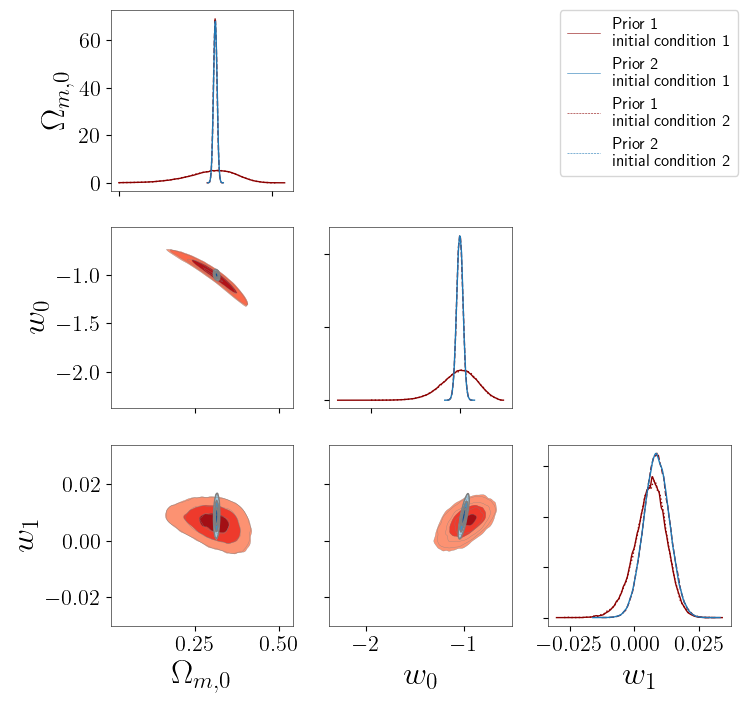

In [41]:
fig1, ax1 = plt.subplots(3,3,figsize=(8,8))
burnin_plot = 1000
plot_results(cpl_ei0p0.idata, burnin_plot, ax=ax1, 
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':':'}})
plot_results(cpl_ei0p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":1, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'--'}})
plot_results(cpl_ei1p0.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ei1p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Blues", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "tab:blue",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
#plot_results(cpl_ei1p2.idata, burnin_plot, ax=ax1,
#            kde_kwargs={"contourf_kwargs": {"cmap": "Blues"}, "contour_kwargs": {"linewidths":0.2}},
#            marginal_kwargs={"color": "tab:blue",'plot_kwargs':{'linewidth':1, 'linestyle':'-.'}})

h_i1p1 = mlines.Line2D([], [], color='darkred', label='Prior 1 \n initial condition 1')
h_i2p1 = mlines.Line2D([], [], color='tab:blue', label='Prior 2 \n initial condition 1')
h_i1p2 = mlines.Line2D([], [], color='darkred', linestyle='--', label='Prior 1 \n initial condition 2')
h_i2p2 = mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Prior 2 \n initial condition 2')

fig1.legend(handles=(h_i1p1, h_i2p1, h_i1p2, h_i2p2), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49));

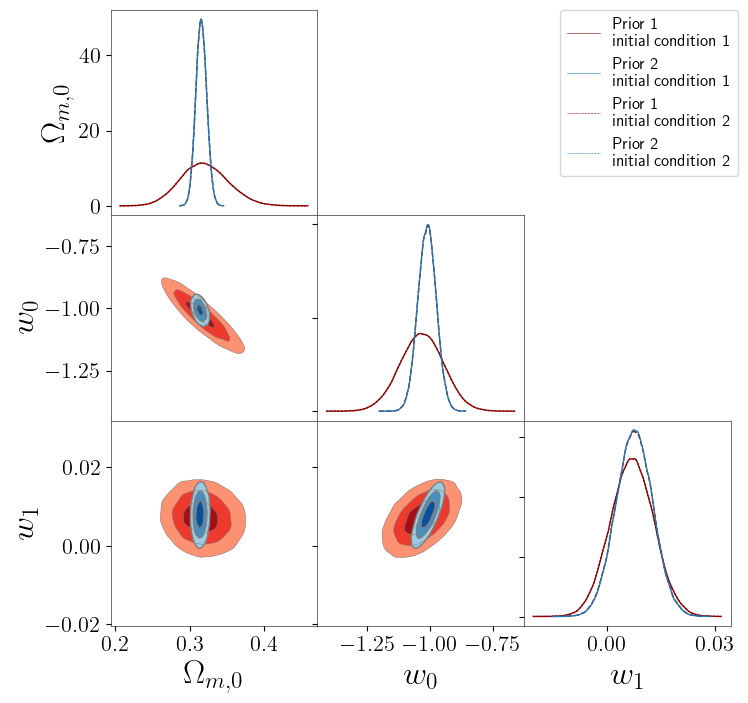

In [358]:
fig1, ax1 = plt.subplots(3,3,figsize=(8,8), gridspec_kw={'wspace':0, 'hspace':0})
burnin_plot = 0
plot_results(cpl_ni0p0.idata, burnin_plot, ax=ax1, 
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':':'}})
plot_results(cpl_ni0p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":1, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'--'}})
plot_results(cpl_ni1p0.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ni1p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Blues", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "tab:blue",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})


ax1[2,2].xaxis.set_major_locator(plt.MaxNLocator(2))


h_i1p1 = mlines.Line2D([], [], color='darkred', label='Prior 1 \n initial condition 1')
h_i2p1 = mlines.Line2D([], [], color='tab:blue', label='Prior 2 \n initial condition 1')
h_i1p2 = mlines.Line2D([], [], color='darkred', linestyle='--', label='Prior 1 \n initial condition 2')
h_i2p2 = mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Prior 2 \n initial condition 2')

fig1.legend(handles=(h_i1p1, h_i2p1, h_i1p2, h_i2p2), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49));

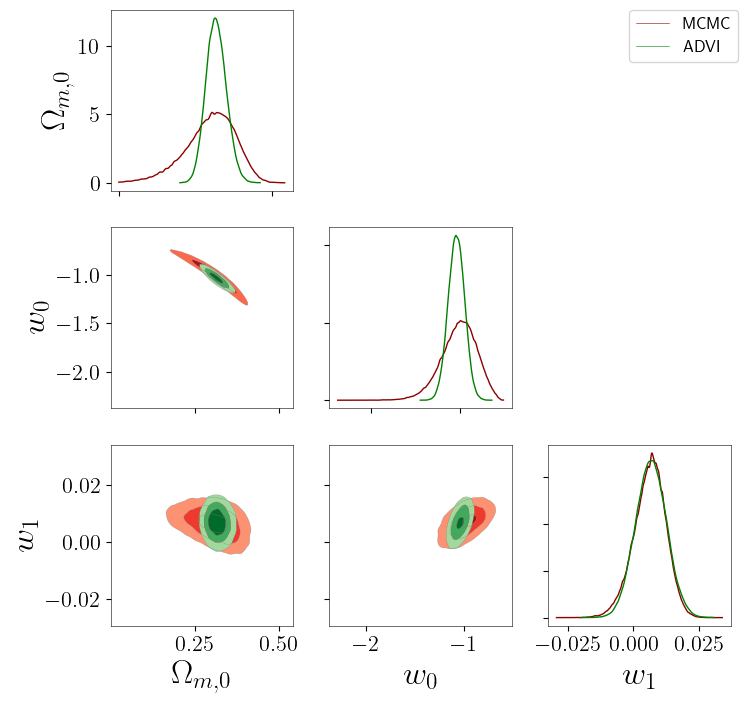

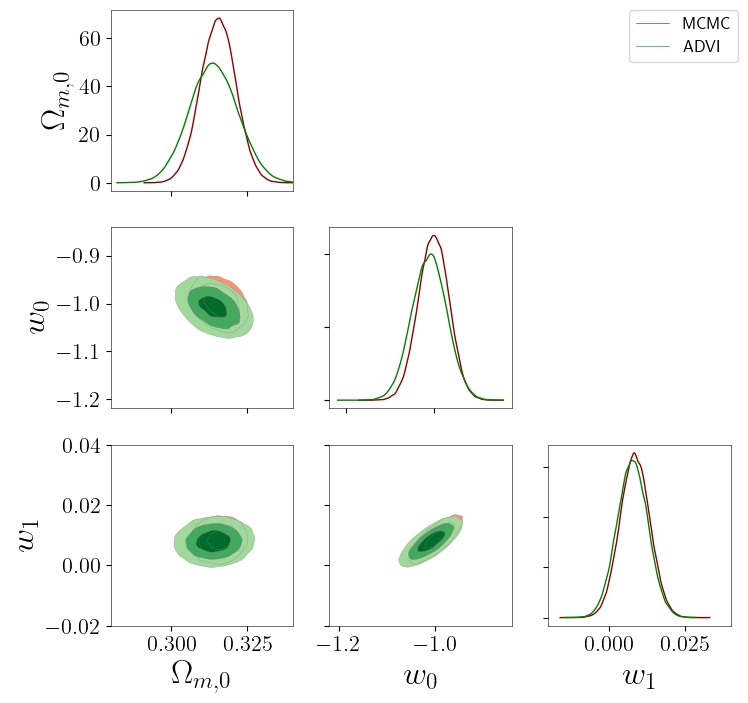

In [43]:
fig, ax = plt.subplots(3,3,figsize=(8,8))
fig1, ax1 = plt.subplots(3,3,figsize=(8,8))
[ax1[i,0].set_xlim(0.28, 0.34) for i in range(3)]
[ax1[2,i].set_ylim(-0.02, 0.04) for i in range(3)]
ax1[2,2].set_xlim(-0.02, 0.04)

burnin_plot = 5000

plot_results(cpl_ei1p0.idata, burnin_plot, ax=ax,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ei1p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, 'levels':3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})

plot_results(cpl_ni1p0.idata,0, ax=ax,
            kde_kwargs={"contourf_kwargs": {"cmap": "Greens", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "green",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ni1p1.idata, 0, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Greens", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "green",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})

h_mcmc = mlines.Line2D([], [], color='darkred', label='MCMC')
h_advi = mlines.Line2D([], [], color='green', label='ADVI')

fig.legend(handles=(h_mcmc, h_advi), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49))
fig1.legend(handles=(h_mcmc, h_advi), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49))

#fig.savefig('../plots/comparison_prior_1.pdf')
#fig1.savefig('../plots/comparison_prior_planck.pdf')

In [137]:
sum_p0 = pd.concat([cpl_ei0p0.summary(), cpl_ei1p0.summary()], keys=['Initial 1', 'Initial 2'])
sum_p1 = pd.concat([cpl_ei0p1.summary(), cpl_ei1p1.summary()], keys=['Initial 1', 'Initial 2'])
sum_pd = pd.concat([sum_p0, sum_p1], keys=['Prior 1', 'Prior 2'])
print(sum_pd.to_latex(escape=False))

\begin{tabular}{lllrrrrr}
\toprule
        &           &       &   mean &  $\sigma$ &  $\mu - \sigma$ &  $\mu + \sigma$ &  $\hat{R}$ \\
\midrule
Prior 1 & Initial 1 & $\Omega_{m,0}$ &  0.366 &     0.183 &           0.212 &           0.408 &       1.28 \\
        &           & $w_0$ & -1.651 &     1.847 &          -1.239 &          -0.752 &       1.29 \\
        &           & $w_1$ &  0.706 &     1.839 &          -0.001 &           0.014 &       1.30 \\
        & Initial 2 & $\Omega_{m,0}$ &  0.299 &     0.081 &           0.239 &           0.393 &       1.00 \\
        &           & $w_0$ & -1.014 &     0.198 &          -1.178 &          -0.793 &       1.00 \\
        &           & $w_1$ &  0.006 &     0.006 &           0.001 &           0.013 &       1.00 \\
Prior 2 & Initial 1 & $\Omega_{m,0}$ &  0.316 &     0.014 &           0.310 &           0.321 &       1.00 \\
        &           & $w_0$ & -0.999 &     0.052 &          -1.035 &          -0.965 &       1.00 \\
        &           

/tmp/ipykernel_24472/430035674.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sum_pd.to_latex(escape=False))


In [124]:
cpl_ni0p0.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Omega_m,0.319,0.035,0.280,0.349,0.0,0.0,98889.0,98266.0,NaN
w_0,-1.034,0.094,-1.127,-0.938,0.0,0.0,98513.0,98063.0,NaN
w_1,0.007,0.006,0.001,0.013,0.0,0.0,99892.0,97141.0,NaN


(24900.0, 25000.0)

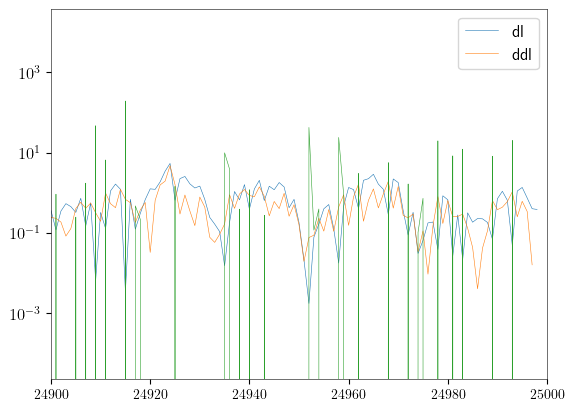

In [225]:
l = jnp.array(cpl_ni1p1.losses)
dl = abs(jnp.diff(l))
ddl = abs(jnp.diff(dl))

#plt.plot(l)
plt.plot(dl, label='dl')
plt.plot(ddl, label='ddl')
plt.plot(ddl/dl[:-1] - 1)
plt.legend()
plt.yscale('log')
plt.xlim(24900,25000)